# Conversion Rate (CR) Prediction Service

The notebook contains EDA, data preparation and modeling experimentation

**Objective**: to build model(s) for predicting users conversion rate probality per keyword depending on the keywords attributes and device used for a search.

**DoD for the model performance**

MSE to be less then the ones can be obtained with the following naïve/baseline models:

- predicting 0 for all entities - baseline0
- predicting the mean of the entire train data set - baseline1
- predicting the mean of the train data set by device - baseline2
- predicting the mean of the train data set by entity_id - baseline3

In [132]:
import os
from collections import namedtuple
from typing import Tuple, NamedTuple, Any
import pandas as pd
import numpy as np
import pandas_profiling
import time
import sklearn
import pickle
from sklearn.metrics import mean_squared_error as MSE
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline
plt.style.use('ggplot')

np.random.seed(2019)

In [2]:
DIR = os.getcwd()
PATH_DATA = os.path.join(os.path.dirname(DIR), 'bucket/data')
PATH_MODEL = os.path.join(os.path.dirname(DIR), 'bucket/model')

In [78]:
df = pd.read_csv(os.path.join(PATH_DATA, 'raw/technical_test_training_data.csv'))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56181 entries, 0 to 56180
Columns: 165 entries, entity_id to Conversions
dtypes: int64(164), object(1)
memory usage: 70.7+ MB


In [5]:
df.profile_report()

Based on the data set profiling, the following conclusions/observation can be made:

- the target class is inbalanced with less than 20% of data points corresponding to a user conversion
- device type distribution is also skewed with the ratio of classes tablet:smartphone:computer ~ 1:1:2
- the data set has the time-series dimensiton and has two weeks worth of data
- number of features can be potentially reduced by omiting some columns due to their correlation:
    - att2 ~ att6 ~ att28
    - att10 ~ att11 ~ att44
    - att17 ~ att19
    - att9 = att35
    - att4 = att26

## Data preparation

The "att" features are binary, hense the following dimensionality reduction "trick" can be employed: 

- concatinate "attXX" features values into one long string "attrs" which can be treated as only *one* (instead of 160) binary number describing a keyword
- convert the "attrs" feature to floating point numbers feature
- scale "attrs" floats between 0 and 1

As the result, a keyword *entity_id* is being described by a unique float instead of 160 bool features.

In [79]:
atts_cols = [i for i in df.columns if i.startswith('att')]
attrs = df[atts_cols]
attrs_int = attrs.apply(lambda x: int(''.join(x.astype(str)), 2), axis=1)

In [80]:
df['attrs'] = attrs_int

Now, we have only one feature which identifies a keyword. Let's however confirm that it's being fully identified by the "attrs" feature value and it doesn't depend on e.g. device.

In [53]:
# check how many entity_id with more then one set of "attXX"/"attrs" exist

sum(df.groupby('entity_id').agg(
    cnt_device = pd.NamedAgg('device', lambda x: x.nunique()),
    cnt_weeks = pd.NamedAgg('week', lambda x: x.nunique()),
    cnt_attrs = pd.NamedAgg('attrs', lambda x: x.nunique())
)['cnt_attrs'] > 1)

0

The data set contains the time-series dimension "week". It is however only two weeks of data present and as discussed with Julien, the seasonality prediction is beyond the scope of this problem. On that basis, the "week" column is being dropped and average conversion rate probability is being calculated across all other feature columns as

$$\frac{\sum_{weeks} Conversions}{\sum_{weeks} Clicks}$$

In [81]:
# find CR using above assumption
df = df.groupby([*['entity_id', 'device', 'attrs'], 
                 *atts_cols], as_index=False)[['Clicks', 'Conversions']].sum()

# 1e-15 term in denominator is to avoid "division by 0" error
df['cr'] = df.apply(lambda x: x['Conversions']/(x['Clicks'] + 1e-15), axis=1)

# filter out irrelevant data points with CR > 1
# the number of conversions exceeding number of clicks doesn't make much sense and may be a sign of broken tracking and data quality issue
df = df[df['cr'] <= 1]

# scale the combined attributes feature to be able to handle it
# otherwise numpy won't be able to allocated enough memory (C int size limitation)
# it's an idvised step anyways to avoid overfit to a particular feature due to its absolute value
max_attrs = int(''.join(['1' for i in range(len(atts_cols))]), 2)
df['attrs_scale'] = (df['attrs']/max_attrs).astype(np.float64)

# convert 3 categiries feature device into two binary fetures: computer, smartphone. 
# we don't need to encode "tablet" category because it's being represented by computer = 0 & smartphone = 0
df['computer'] = 0
df.loc[df['device']=="Computer", 'computer'] = 1
df['smartphone'] = 0
df.loc[df['device']=="Smartphone", 'smartphone'] = 1

# drop columns not in use
df.drop(['Clicks', 'Conversions', 'attrs', 'device'], axis=1, inplace=True)

A generally good practice is, to downcast the data types to reduce RAM consumtion for storage and to optimize training process. This step is advised to use (especially when it comes to floating point data type) to remove unnessesarly precision to reduce computation complexety

In [94]:
def type_downcast(vec: pd.Series) -> pd.Series:
    """Function to downcast data type of the feature
    
    Args:
        vec: pd.Series vector
       
    Returns:
        pd.Series
    """
    _types = namedtuple('types', ['int', 'float'])
    types = _types(int=[f"np.int{i}" for i in [8, 16, 32, 64]],
                   float=[f"np.float{i}" for i in [16, 32, 64, 128]])

    vec_dtype = vec.dtype
    if vec_dtype not in types._fields:
        return vec
    
    col_min = vec.min()
    col_max = vec.max()
    
    for tid, type_class in enumerate(types._fields):
        if vec_dtype != type_class:
            continue
    
        for _type in types[tid]:
            if type_class == 'int':
                type_min, type_max = np.iinfo(eval(_type)).min, np.iinfo(eval(_type)).max
            elif type_class == 'float':
                type_min, type_max = np.finfo(eval(_type)).min, np.finfo(eval(_type)).max
            else:
                break            
            if type_min <= col_min and col_max <= type_max:
                    return vec.astype(eval(_type), copy=True)

In [95]:
for col in df.columns:
    # attrs_scale feature to be kept as float64 to avoid losing precision for this feature
    if col != 'attrs_scale': 
        try:
            df.loc[:, col] = type_downcast(df[col])
        except Exception as ex:
            continue

In [101]:
# save preprocessed data
df.to_csv(os.path.join(PATH_DATA, 'processed/data.csv.gz'), index=False)

## Modeling

In general, it is a decent technique to follow an iterative modelling approach:

identify baseline (business objectives most of the times) -> base features -> simple model -> production -> model preformance improvement iterations until business objectives hit

Model performance can be improved by combining the following options:

- get higher volume of data (number of data points)
- feature engineering (number of features and their correlation to the target/predictor)
- model fine tunining (existing model hyperparameters tuning)
- increase model complexity (switch from simple regressior to ANN, GBM etc.)

### Baseline

Let's check performace of the baseline models noted in problem statement

In [102]:
# baseline models performance

def baseline_mse(d: pd.DataFrame) -> dict:    
    """Function to calculate MSE * 10e5 of the baseline models"""
    # model baseline0
    d['baseline0'] = 0 
    
    # model baseline1
    d['baseline1'] = d['cr'].mean()
    
    # model baseline2
    d = d.merge(d.groupby(['computer', 'smartphone']).agg(
        baseline2 = pd.NamedAgg('cr', np.mean)
    ), on=['computer', 'smartphone'])
    
    # model baseline3
    d = d.merge(d.groupby(['entity_id']).agg(
        baseline3 = pd.NamedAgg('cr', np.mean)
    ), on=['entity_id'])
    
    metrics = {
        i: int(MSE(d['cr'], d[i]) * 10e5) for i in [col for col in d.columns
                                            if col.startswith('baseline')]
    }
    
    return metrics

In [103]:
# check metrics across devices for prediction across 

baseline_mse(df.copy())

{'baseline0': 21002, 'baseline1': 19119, 'baseline2': 19027, 'baseline3': 7625}

It is worth mentioning that the *baseline3* model predicts CR per entity_id as it is equal to the averaged CR value across entity_id hanse it is overfitting to an individual data point. Moreover MSE of baseline3 model is skewed towards 0 because about 45% of keywords/entity_id values from data sample have only one data point which would correspond to zero error "prediction" done by model3:

In [106]:
datapoints_per_keyword = df.groupby('entity_id', as_index=False)[['computer', 'smartphone']].agg('count')\
                           .groupby(['computer', 'smartphone'], as_index=False).agg('count')[['computer', 'entity_id']]
datapoints_per_keyword.columns = ['cnt_data_points', 'share']
datapoints_per_keyword.loc[:, 'share'] = datapoints_per_keyword['share']/df['entity_id'].nunique()
datapoints_per_keyword

cnt_data_points     share
0                1  0.457722
1                2  0.253073
2                3  0.289205

On that basis, the main objective for solution would be to build a model to "beat" *baseline{0-2}* in tearms of MSE.

## Pearson correlation coeffitient

In [107]:
cols = [*['cr', 'computer', 'smartphone', 'attrs_scale'], *atts_cols]
corr = df[cols].corr()['cr']

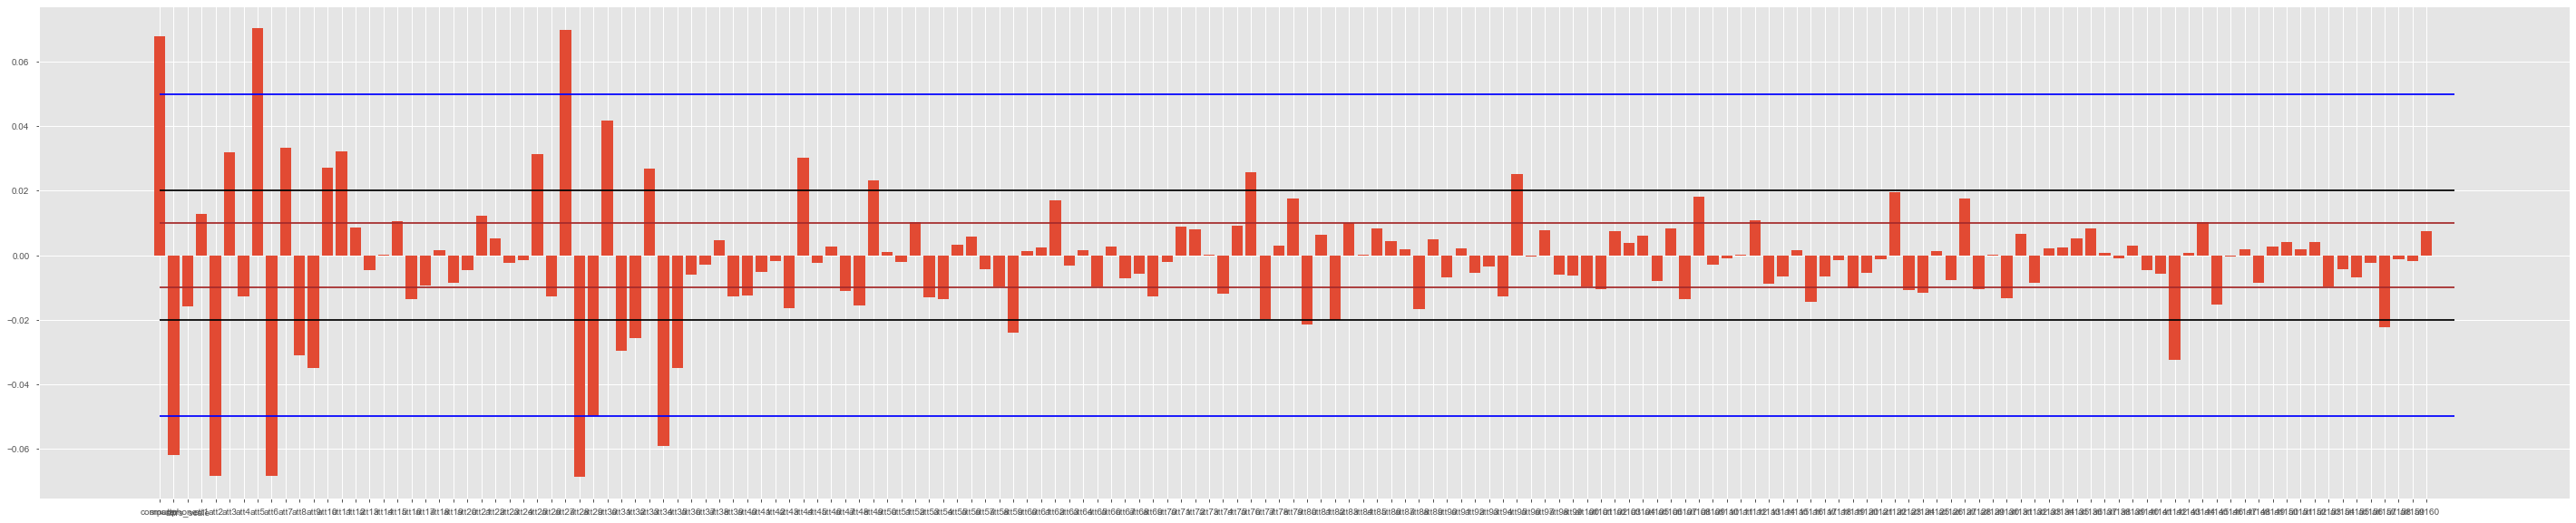

In [108]:
# let's have a look at the Pearson's corr distribution across all features

plt.figure(figsize=(50, 10))
plt.bar(x=[i for i in cols 
           if i != 'cr'],
        height=corr[1:])
plt.hlines(y=[-0.05, 0.05], 
           xmin=0, xmax=len(cols), 
           colors='b')
plt.hlines(y=[-0.02, 0.02], 
           xmin=0, xmax=len(cols), 
           colors='k')
plt.hlines(y=[-0.01, 0.01], 
           xmin=0, xmax=len(cols), 
           colors='brown')
plt.show()


## Feature engineering v1

Train models using the following features:
- device (computer+smartphone columns)
- attrs_scale
- att6 and att28 to be excluded because they are highly correlated with att2
- att9 used instead of att35 (att35 to be excluded) since they are 100% correlated
- top 10 highly linearly correlated features

In [109]:
features_top10 = [i for i in pd.DataFrame({'corr': corr[1:],
                                           'abs': abs(corr[1:])
                                          }).sort_values(by=['abs'], 
                                                         ascending=False)['corr'].index
                  if i not in ['computer', 'smartphone', 'att6', 'att28', 'att35']][:10]

In [112]:
# list of features
cols_v1 = [*['cr', 'entity_id', 'computer', 'smartphone', 'attrs_scale'],
           *features_top10]

In [113]:
df_v1 = df[cols_v1].copy().reset_index(drop=True)

In [114]:
# save v1 data sample
df_v1.to_csv(os.path.join(PATH_DATA, 'processed/data_v1.csv.gz'), index=False)

### Prepare a train/eval data split

In [115]:
train_ids = list(pd.Series(df_v1.index).sample(frac=0.8, random_state=2019))

In [116]:
df_v1_train = (df_v1[df_v1.index.isin(train_ids)].copy()).reset_index(drop=True)
df_v1_eval = (df_v1[~df_v1.index.isin(train_ids)].copy()).reset_index(drop=True)

In [117]:
# save train/eval data sets
df_v1_train.to_csv(os.path.join(PATH_DATA, 'train/v1/train.csv.gz'), index=False)
df_v1_eval.to_csv(os.path.join(PATH_DATA, 'train/v1/eval.csv.gz'), index=False)

### v1 model

Let's start off with linear regressor

In [118]:
from sklearn import linear_model

In [119]:
model_v1 = linear_model.LinearRegression(n_jobs=-1)

In [120]:
model_v1.fit(df_v1_train.drop(['cr', 'entity_id'], axis=1), df_v1_train['cr'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [121]:
def model_mse(model, 
              df_train: pd.DataFrame, 
              df_eval: pd.DataFrame, 
              df_overall: pd.DataFrame, 
              col_lose: []) -> dict:
    """Function to calculate MSE * 10e5 for train/eval/averall datasets
    
    Args:
        model: model to predict CR
        df: DataFrame to predict on
        col_lose: list of colums to drop from features to predict on
    
    Returns:
        dict with MSE value evaluated on tran, evan and overall data sets
    """
    return {
        "train": int(MSE(df_train['cr'], 
                         model.predict(df_train.drop(col_lose, axis=1))) * 10e5),
        "eval": int(MSE(df_eval['cr'], 
                        model.predict(df_eval.drop(col_lose, axis=1))) * 10e5),
        "overall": int(MSE(df_overall['cr'], 
                           model.predict(df_overall.drop(col_lose, axis=1))) * 10e5)
    }

In [122]:
model_mse(model_v1, 
          df_train=df_v1_train,
          df_eval=df_v1_eval,
          df_overall=df_v1,
          col_lose=['cr', 'entity_id'])

{'train': 18957, 'eval': 17854, 'overall': 18736}

In [123]:
# compare to baseline on eval data
baseline_mse(df_v1_eval.copy())

{'baseline0': 20006, 'baseline1': 18249, 'baseline2': 18112, 'baseline3': 1803}

A simple linear regression has a better performance compared to the baseline models. 

Save and deploy the model -> service MVP. Implementation of a service to re-train the model to be done as weel (see README.md for details) 

In [124]:
with open(os.path.join(PATH_MODEL, "v1/model.pkl"), 'wb') as f:
    pickle.dump(model_v1, f)

### v2 model

Let's build GBM to improve overall performance and to define features importance

In [125]:
from xgboost import XGBRegressor
import xgboost as xgb

In [126]:
parameters = {
    "learning_rate": 0.1,
    "n_estimators": 40, 
    "max_depth": 10
}

dropped columns: 
{'train': 18708, 'eval': 17946, 'overall': 18556}
dropped columns: computer, smartphone
{'train': 18963, 'eval': 18107, 'overall': 18792}
dropped columns: attrs_scale
{'train': 18834, 'eval': 17958, 'overall': 18658}
dropped columns: computer, smartphone, attrs_scale
{'train': 19053, 'eval': 18106, 'overall': 18864}


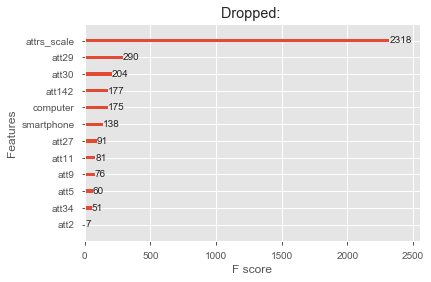

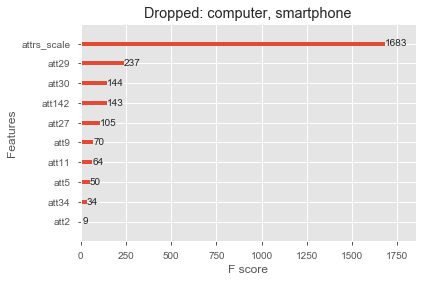

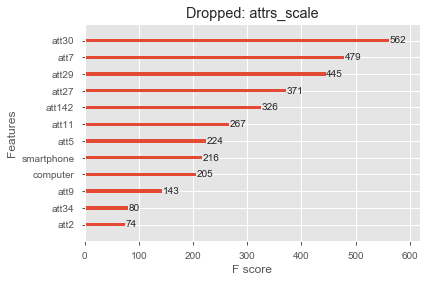

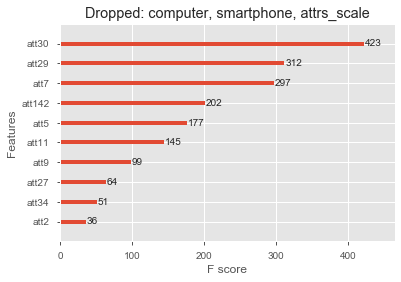

In [127]:
# check the features importance by dropping additional

cols_lose0 = ['cr', 'entity_id']
cols_lose = [[],
             ['computer', 'smartphone'],
             ['attrs_scale'],
             ['computer', 'smartphone', 'attrs_scale']]

for i in cols_lose:
    print(f"dropped columns: {', '.join(i)}")
    model_v2 = XGBRegressor(**parameters, 
                            verbosity=1, 
                            objective='reg:squarederror')

    model_v2.fit(df_v1_train.drop([*cols_lose0, *i], axis=1), 
                 df_v1_train['cr'],
                 verbose=True)
    
    mse = model_mse(model_v2, 
                    df_v1_train,
                    df_v1_eval,
                    df_v1,
                    [*cols_lose0, *i])
    print(mse)
    xgb.plot_importance(model_v2, 
                        title=f"Dropped: {', '.join(i)}")

Despite of the fact that the model overfits to the "attrs_scale" it has the highest performance compared to the other four XGB models. It makes sense since attrs_scale fully represents a given keyword/entity_id.

More data and further retraining can improve the MSE peformance. Another approach would be to split the task and first, predict the class CR > 0 -> 1, or CR = 0 -> 0.

In [128]:
# re-train and save the model with all features selected for the data set v1
model_v2 = XGBRegressor(**parameters, 
                        verbosity=1, 
                        objective='reg:squarederror')

model_v2.fit(df_v1_train.drop(cols_lose0, axis=1), 
             df_v1_train['cr'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=40,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [129]:
model_mse(model_v2, 
          df_train=df_v1_train,
          df_eval=df_v1_eval,
          df_overall=df_v1,
          col_lose=['cr', 'entity_id'])

{'train': 18708, 'eval': 17946, 'overall': 18556}

In [130]:
with open(os.path.join(PATH_MODEL, "v2/model.pkl"), 'wb') as f:
    pickle.dump(model_v2, f)

### v3 model - hyperparameters tuning of the model model_v2

As further steps, the following can be done:

- model_v2 overfit to the train subset can be reduced
- model fine tune can be performed; [aws sagemaker](https://aws.amazon.com/sagemaker/), or [gcp ml engine](https://cloud.google.com/ml-engine/) can be used for hyperparameters fine tuning

In [133]:
from sklearn.model_selection import GridSearchCV

def model_pipeline(X_train: pd.DataFrame, 
                   y_train: pd.Series, 
                   X_eval: pd.DataFrame, 
                   y_eval: pd.Series, 
                   model: Any, 
                   param_grid: dict, 
                   cv: int, 
                   loss: str) -> Tuple[Any, dict]:
    """Function to form a CV pipeline + gridsearch
    
    Args:
        X_train, y_train: train features and target
        X_eval, y_eval: eval features and target
        model: model object
        param_grid: grid to search over
        cv: number of cross-validations
        loss: name of loss function, see sklearn.metrics.SCORERS.keys() for details
    """
    if model is None:
        raise Exception("No model supplied")
        return

    grid = GridSearchCV(estimator=model,
                        param_grid=param_grid, 
                        cv=cv,
                        n_jobs=-1, 
                        scoring=loss,
                        verbose=0)

    fitted_model = grid.fit(X_train, y_train, 
                            eval_set=[(X_train, y_train), (X_eval, y_eval)], 
                            verbose=False,
                            early_stopping_rounds=5)
    
    return fitted_model.best_estimator_, fitted_model.best_params_

In [134]:
parameters = {
    "learning_rate": [0.1],
    "n_estimators": [50, 100], 
    "max_depth": [10, 15],
    "reg_gamma": [0.8]
}

In [135]:
model_v3, params_best = model_pipeline(df_v1_train.drop(cols_lose0, axis=1), 
                                       df_v1_train['cr'], 
                                       df_v1_eval.drop(cols_lose0, axis=1), 
                                       df_v1_eval['cr'], 
                                       XGBRegressor(verbosity=0, 
                                                    n_jobs=-1,
                                                    objective='reg:squarederror'),
                                       parameters, 
                                       cv=2, 
                                       loss='neg_mean_squared_error')

In [136]:
model_mse(model_v3, 
          df_v1_train,
          df_v1_eval,
          df_v1,
          cols_lose0)

{'train': 18647, 'eval': 17927, 'overall': 18503}

In [137]:
# Illustrate the training process

train_results_v3 = model_v3.evals_result()
def plotter(epochs=[]):
    steps = range(len(train_results_v3['validation_0']['rmse']))

    if len(epochs) > 0:
        steps = epochs
    
    fig = plt.figure(figsize=(50, 10))
    plt.plot(steps, np.square(train_results_v3['validation_0']['rmse'])[steps], label='Train')
    plt.plot(steps, np.square(train_results_v3['validation_1']['rmse'])[steps], label='Eval')
    plt.ylabel('MSE', fontdict={'fontsize': 40})
    plt.yticks(size=20)
    plt.xticks(size=20)
    plt.legend(fontsize=30)
    plt.title('Training process', fontdict={'fontsize': 40})
    plt.show()

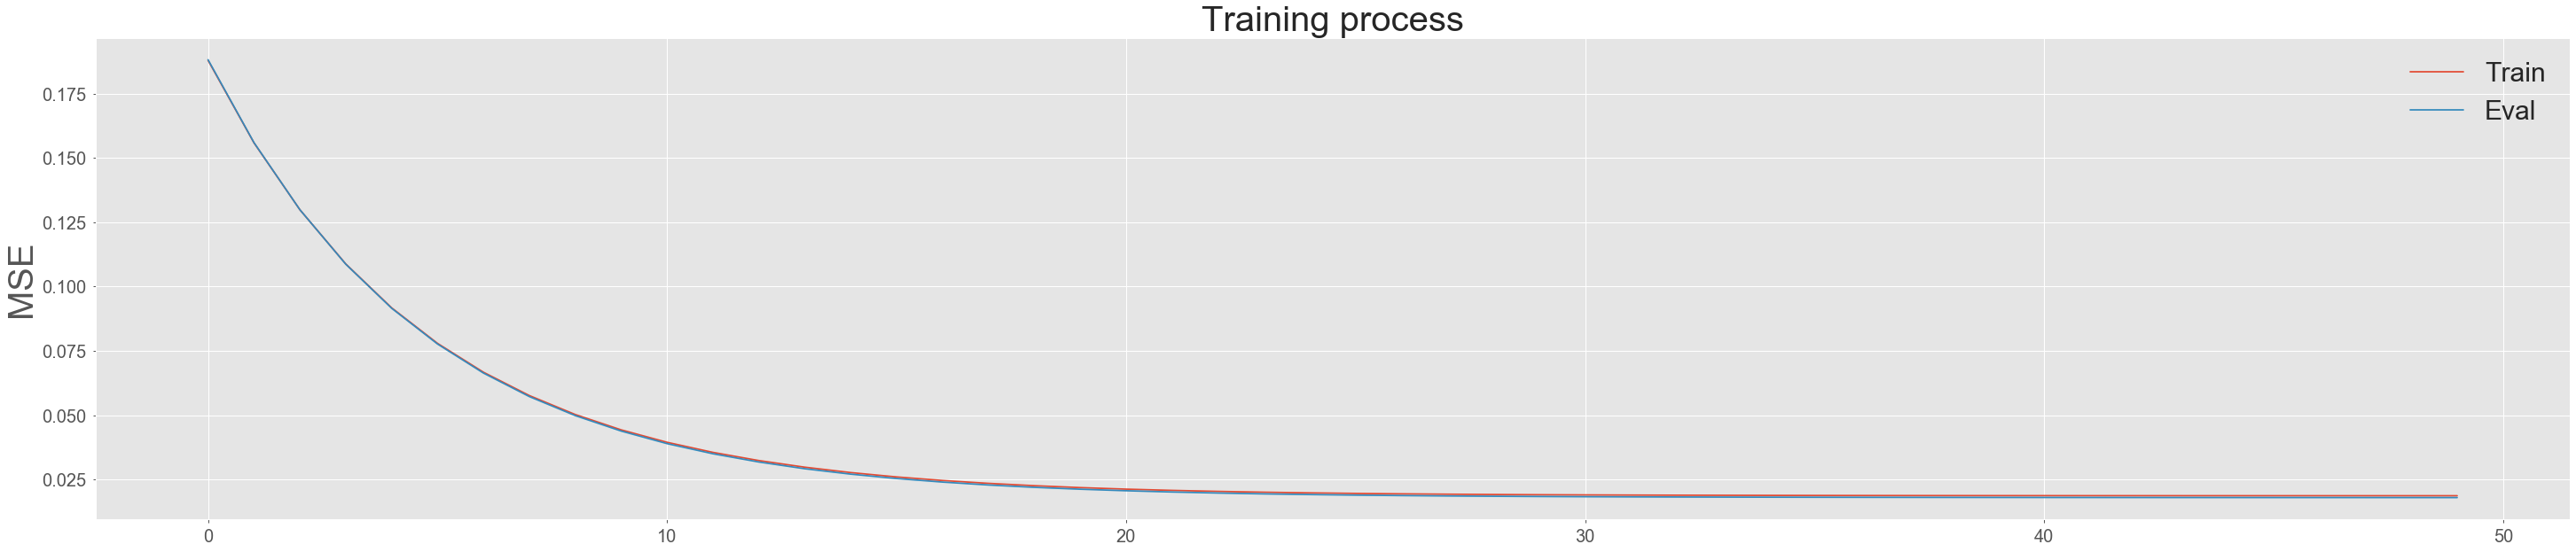

In [138]:
plotter()

One can see that the model overfits to the train data set

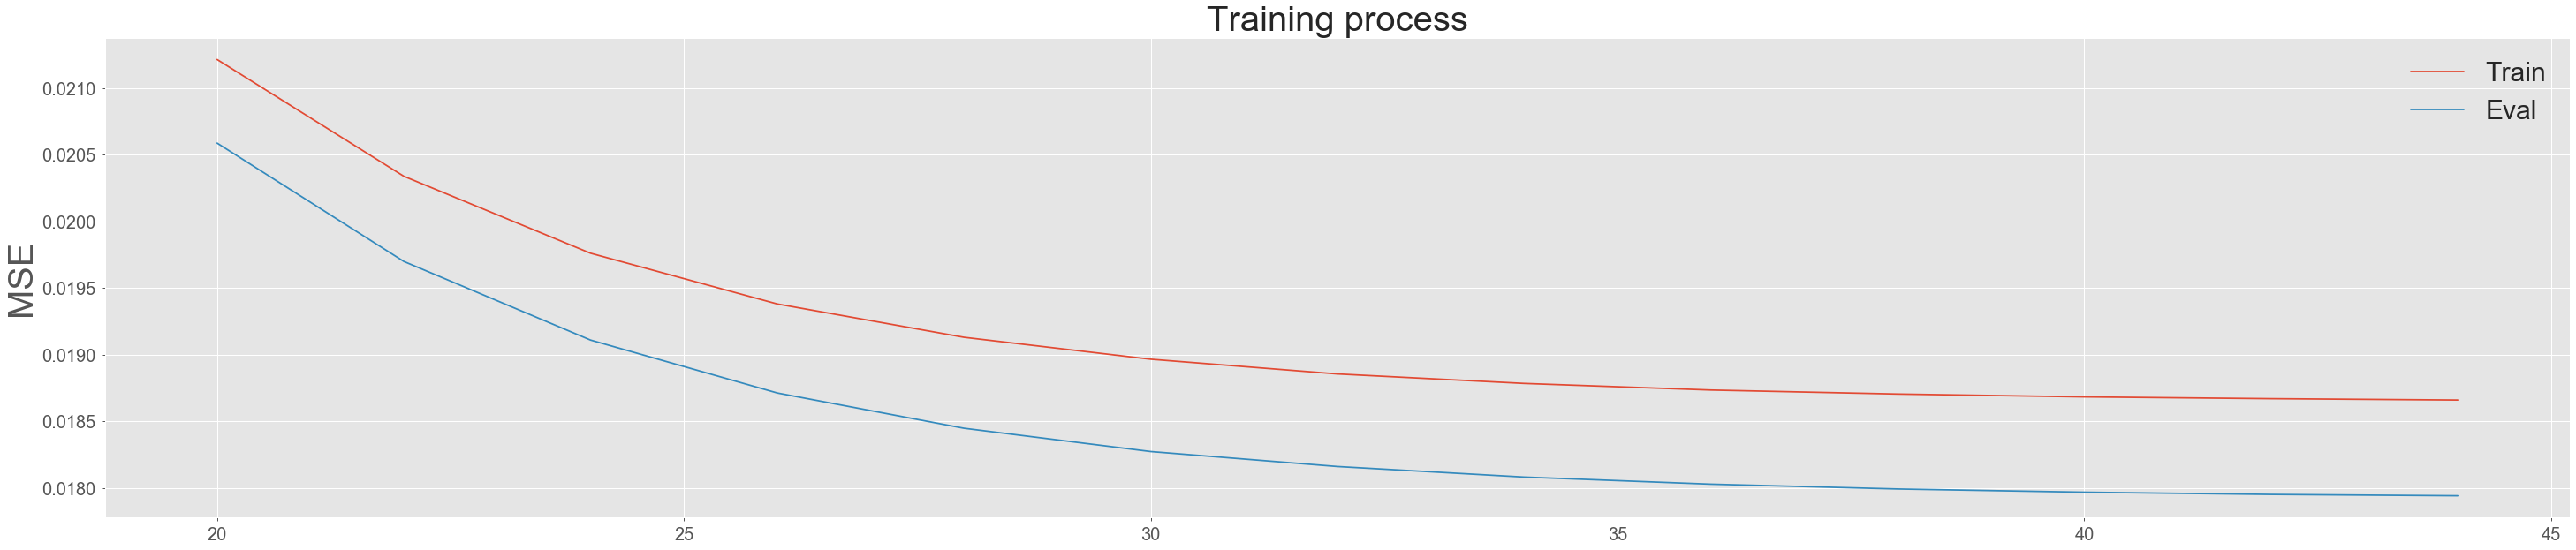

In [139]:
plotter(epochs=[i for i in range(20, 45, 2)])

In [140]:
with open(os.path.join(PATH_MODEL, "v3/model.pkl"), 'wb') as f:
    pickle.dump(model_v3, f)

model_v3 has less than 1% performance improvement compared to the model_v2, it is however 2.5 times more complex (it requires more storage, disk and RAM space) and would be more computational resources demanding to run prediction.

In [141]:
# let's compare the disk space required be the models

! du -h ${PWD}/../bucket/model/v{1,2,3}/model.pkl

4.0K	/Users/dkisler/projects/sellics_challenge/analytics/../bucket/model/v1/model.pkl
268K	/Users/dkisler/projects/sellics_challenge/analytics/../bucket/model/v2/model.pkl
616K	/Users/dkisler/projects/sellics_challenge/analytics/../bucket/model/v3/model.pkl


## v4 - DNN

In [142]:
import tensorflow as tf

In [143]:
def dnn_config1():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(13, input_shape=(13,),
                                    name="l_0",
                                    activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dense(10,
                                    name="l_1",
                                    activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dense(5,
                                    name="l_2",
                                    activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dense(1, 
                                    name="l_out",
                                    activation='linear'))
    return model

def dnn_config2():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, input_shape=(13,),
                                    name="l_0",
                                    activation=tf.keras.activations.relu, 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(64,
                                    name="l_1",
                                    activation=tf.keras.activations.relu, 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01)))
    model.add(tf.keras.layers.Dense(1, 
                                    name="l_out",
                                    activation='linear'))
    return model

def dnn_config3():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(13, input_shape=(13,),
                                    name="l_0",
                                    activation=tf.keras.activations.relu, 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10,
                                    name="l_1",
                                    activation=tf.keras.activations.relu, 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01)))
    model.add(tf.keras.layers.Dense(5,
                                    name="l_2",
                                    activation=tf.keras.activations.relu, 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01)))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(1, 
                                    name="l_out",
                                    activation='linear'))
    return model

In [144]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
batch_size = 32
epochs = 10

In [145]:
for i in range(1, 4, 1):
    model_dnn = eval(f"dnn_config{i}()")
    model_dnn.compile(optimizer=optimizer,
                     loss=tf.keras.metrics.mse,
                     metrics=[tf.keras.metrics.mse])
    model_dnn.fit(df_v1_train.drop(['cr', 'entity_id'], axis=1), df_v1_train['cr'], 
                  validation_data=(df_v1_eval.drop(['cr', 'entity_id'], axis=1), df_v1_eval['cr']), 
                  batch_size=batch_size, 
                  epochs=epochs, 
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              min_delta=0.0001, 
                                                              mode='auto', 
                                                              patience=2, 
                                                              verbose=0,
                                                              restore_best_weights=True)],
                  workers=-1)
    
    print(f"dnn_config{i} MSE: {MSE(df_v1_eval['cr'], model_dnn.predict(df_v1_eval.drop(['cr', 'entity_id'], axis=1)))}")

Train on 29683 samples, validate on 7421 samples
Epoch 1/10
29683/29683 [==============================] - 2s 78us/sample - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 2/10
29683/29683 [==============================] - 2s 68us/sample - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 3/10
29683/29683 [==============================] - 2s 59us/sample - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
dnn_config1 MSE: 0.01803896389901638
Train on 29683 samples, validate on 7421 samples
Epoch 1/10
29683/29683 [==============================] - 3s 90us/sample - loss: 0.1976 - mean_squared_error: 0.0202 - val_loss: 0.1042 - val_mean_squared_error: 0.0185
Epoch 2/10
29683/29683 [==============================] - 2s 71us/sample - loss: 0.0959 - mean_squared_error: 0.0194 - val_loss: 0.0866 - val_mean_squared_error: 0.0182
Epoch 3/10
29683/296

DNN is a complex model which flexibility may potentially lead to a reduction of overall MSE, this process however would require higher time investments and hence it is beyond the problem scope. 

Its performace in tearms of MSE however is not imrpoving by incleasing model's complexity (e.g. by adding more hidden layers) though. It means that further CR model improvement may be achieved by training model on mode data, or by further feature engineering. Let's see performance improvement for the *model_v{1-4}*.

## Models performance comparison

In [146]:
baseline_performance0 = {
    "train": baseline_mse(df_v1_train.copy()),
    "eval": baseline_mse(df_v1_eval.copy()),
    "overall": baseline_mse(df_v1.copy())
}

In [147]:
baseline_performance = {}
for k, v in baseline_performance0.items():
    for k1, v1 in v.items():
        if k1 == 'baseline3':
            continue
        if k1 not in baseline_performance:
            baseline_performance[k1] = {} 
        baseline_performance[k1][k] = v[k1]

In [148]:
performance = baseline_performance

for i in [1, 2, 3]:
    model_ver = f"model_v{i}"
    performance[model_ver] = model_mse(eval(model_ver), 
                                       df_v1_train,
                                       df_v1_eval,
                                       df_v1,
                                       cols_lose0)

In [149]:
performance = pd.DataFrame(performance).T
performance['model'] = performance.index
performance.reset_index(drop=True, inplace=True)
performance['overall_improvement_pct'] = round(abs(performance['overall'].diff())/performance['overall'] * 100, 1)

In [150]:
performance

train   eval  overall      model  overall_improvement_pct
0  21251  20006    21002  baseline0                      NaN
1  19348  18249    19119  baseline1                      9.8
2  19256  18112    19027  baseline2                      0.5
3  18957  17854    18736   model_v1                      1.6
4  18708  17946    18556   model_v2                      1.0
5  18647  17927    18503   model_v3                      0.3

A gradual drop of MSE can be seen in the table above, models complexity brings however an under 1% performance improvement. It means that any further MSE drop can be achieved by training on more data (beyond the scope of the problem), or by performing further feature engineering.

## Further ideas
(a demo/discussion of what could be done beyond this task solution)

Build ansamble models:

1. binary classificator to predict if a keyword leads to a conversion, or not: "class 0" if CR = 0, "class 1" if CR > 0    
2. regressor to predict value of CR probability

Classification model would require over/undersampling to be employed to balance classes distribution. Regressor may require more data points for performance improvement in terms of MSE.

## Feature engineering - data classes balancing

One can try employing different data balancing techniques, e.g. to use SMOTE oversampling method from [imblearn](https://imbalanced-learn.readthedocs.io/) library, or to make a random data subsetting by following the steps:

* select data points with cr>0 as d_positive. size0=len(d_positive)
* randomly subset the data with cr==0 to the size=size0, d_negative
* randomly subset d_positive to the size of alpha*size0 -> d_positive_sub
* randomly subset d_negative to the size of alpha*size0 -> d_negative_sub
* union(d_positive_sub, d_negative_sub) -> df_balanced
* randomly shuffle df_balanced

*alpha* is a sampling hyper-parameter between 0 and 1.

The model can be re-trained on the balanced data set using several sampling iterations in a loop.

## SMOTE

In [515]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [516]:
oversampling = SMOTE(sampling_strategy='minority',
                     random_state=2019)

In [641]:
oversampling.fit(df_v1_train.drop(['cr', 'entity_id'], axis=1), df_v1_train['cr'])

SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
      out_step='deprecated', random_state=2019, ratio=None,
      sampling_strategy='minority', svm_estimator='deprecated')

## Random subsampling

In [152]:
def data_balancing(df: pd.DataFrame, 
                   alpha=0.7,
                   random_state=(1, 2)) -> Tuple[pd.DataFrame, 
                                                 pd.DataFrame, 
                                                 pd.Series, 
                                                 pd.Series]:
    """Function to balance data set
    
    Args:
        df: input data frame
        alpha: balancing paramter
        random_state: tuple of random states to set seed
    
    Returns:
        Tuple of X_train, X_test, y_train, y_test
    """
    d_positive = df[df['cr'] > 0]
    size = int(alpha * len(d_positive))

    d_positive_sub = d_positive.sample(size, 
                                       replace=False, 
                                       random_state=random_state[0])    
    d_negative_sub = df[df['cr'] == 0].sample(size, 
                                              replace=False, 
                                              random_state=random_state[0])
    
    d_combined = pd.concat([d_positive_sub,
                            d_negative_sub],
                           axis=0)\
                   .sample(frac=1, 
                           random_state=random_state[1])\
                   .reset_index(drop=True)

    del d_positive_sub, d_positive, d_negative_sub, size

    X_train, X_test, y_train, y_test = train_test_split(d_combined.drop(['cr'], axis=1), 
                                                        d_combined['cr'], 
                                                        test_size=0.2, 
                                                        shuffle=True, 
                                                        random_state=2019)
    return X_train, X_test, y_train, y_test